In [1]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# Config

In [2]:
batch_size = 128
Z_dim = 100        # demesion of noise vector z for generator input
max_iter = 1000000
mnist = input_data.read_data_sets('//data/examples/MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting //data/examples/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting //data/examples/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting //data/examples/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting //data/examples/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 定義 generator & discriminator 

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

#### Define model ####
def generator(z):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):  
        with tf.variable_scope('hidden_layer'):
            g_w1 = tf.get_variable(name="weight_1", dtype=tf.float32, initializer=xavier_init([100, 128]))
            g_b1 = tf.get_variable(name="bias_1", dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            g_h1 = tf.nn.relu(tf.matmul(z, g_w1) + g_b1)
            
        with tf.variable_scope('output_layer'):
            g_w2 = tf.get_variable(name="weight_2", dtype=tf.float32, initializer=xavier_init([128, 784]))
            g_b2 = tf.get_variable(name="bias_2", dtype=tf.float32, initializer=tf.zeros(shape=[784]))
            g_prob = tf.nn.sigmoid(tf.matmul(g_h1, g_w2) + g_b2)
                       
    return g_prob

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('hidden_layer'):
            d_w1 = tf.get_variable(name="weight_1", dtype=tf.float32, initializer=xavier_init([784, 128]))
            d_b1 = tf.get_variable(name="bias_1", dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            d_h1 = tf.nn.relu(tf.matmul(x, d_w1) + d_b1)
            
        with tf.variable_scope('output_layer'):
            d_w2 = tf.get_variable(name="weight_2", dtype=tf.float32, initializer=xavier_init([128, 1]))
            d_b2 = tf.get_variable(name="bias_2", dtype=tf.float32, initializer=tf.zeros(shape=[1]))
            d_logit = tf.matmul(d_h1, d_w2) + d_b1
            d_prob = tf.nn.sigmoid(d_logit)
            
    return d_prob, d_logit

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行



In [4]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    #### placeholder ####
    Z = tf.placeholder(name='z', dtype=tf.float32, shape=[None, 100])
    input_img = tf.placeholder(name='real_img', dtype=tf.float32, shape=[None, 784])

    #### GAN model output ####  
    g_sample = generator(Z)
    d_fake, d_logit_fake = discriminator(g_sample)
    d_real, d_logit_real = discriminator(input_img)

    #### loss ####
    d_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logit_real, labels=tf.ones_like(d_logit_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))

    #### variable list ####
    varList = tf.trainable_variables()
    g_varList = [var for var in varList if 'generator' in var.name]
    d_varList = [var for var in varList if 'discriminator' in var.name]
    
    #### update ####
    d_optimizer = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_varList)
    g_optimizer = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_varList)

    init = tf.global_variables_initializer()

### Tensorflow- 初始化模型

In [5]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [6]:
def sample_Z(m, n):
    return np.random.uniform(-1, 1, size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        
    return fig

Iter: 0
D loss: 621.1
G_loss: 621.1


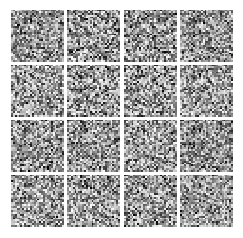

############################
Iter: 1000
D loss: 642.9
G_loss: 642.9


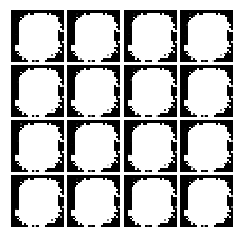

############################
Iter: 2000
D loss: 687.3
G_loss: 687.4


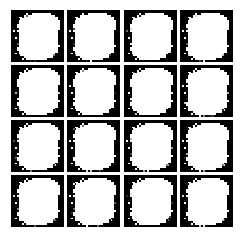

############################
Iter: 3000
D loss: 725.4
G_loss: 725.3


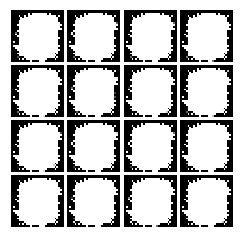

############################
Iter: 4000
D loss: 757.5
G_loss: 757.5


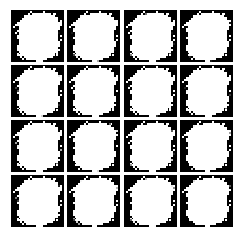

############################
Iter: 5000
D loss: 783.9
G_loss: 784.0


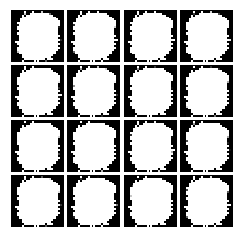

############################
Iter: 6000
D loss: 810.9
G_loss: 810.1


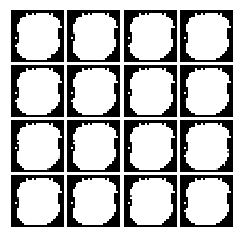

############################
Iter: 7000
D loss: 838.6
G_loss: 839.7


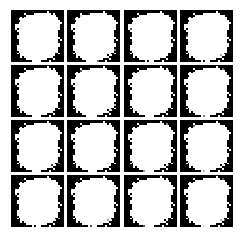

############################
Iter: 8000
D loss: 865.9
G_loss: 869.1


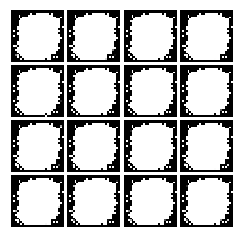

############################
Iter: 9000
D loss: 893.8
G_loss: 896.9


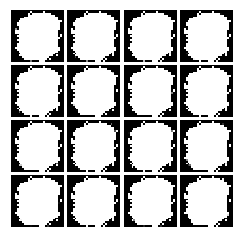

############################
Iter: 10000
D loss: 921.7
G_loss: 922.7


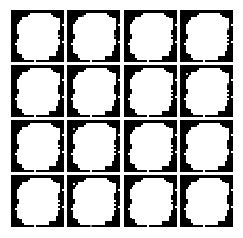

############################
Iter: 11000
D loss: 949.4
G_loss: 946.3


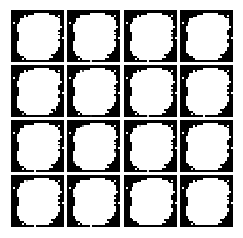

############################
Iter: 12000
D loss: 976.4
G_loss: 978.5


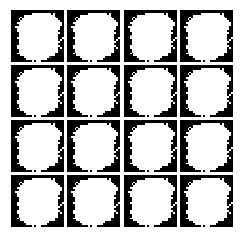

############################
Iter: 13000
D loss: 1.004e+03
G_loss: 1.003e+03


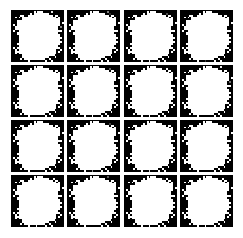

############################
Iter: 14000
D loss: 1.032e+03
G_loss: 1.029e+03


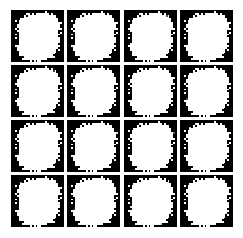

############################
Iter: 15000
D loss: 1.059e+03
G_loss: 1.062e+03


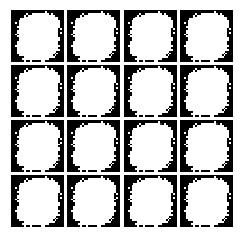

############################
Iter: 16000
D loss: 1.084e+03
G_loss: 1.095e+03


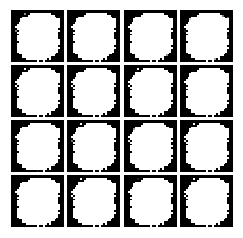

############################
Iter: 17000
D loss: 1.112e+03
G_loss: 1.11e+03


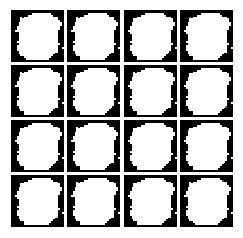

############################
Iter: 18000
D loss: 1.138e+03
G_loss: 1.181e+03


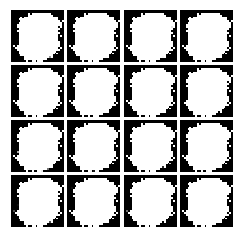

############################
Iter: 19000
D loss: 1.163e+03
G_loss: 1.166e+03


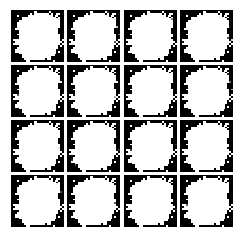

############################
Iter: 20000
D loss: 1.194e+03
G_loss: 1.231e+03


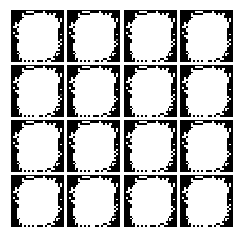

############################
Iter: 21000
D loss: 1.222e+03
G_loss: 1.194e+03


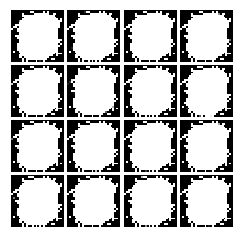

############################
Iter: 22000
D loss: 1.249e+03
G_loss: 1.273e+03


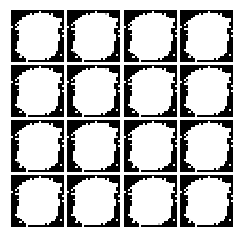

############################
Iter: 23000
D loss: 1.276e+03
G_loss: 1.25e+03


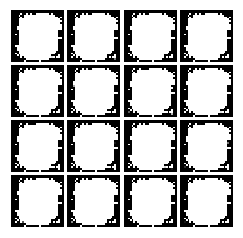

############################
Iter: 24000
D loss: 1.301e+03
G_loss: 1.315e+03


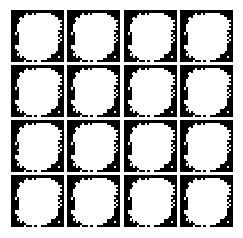

############################
Iter: 25000
D loss: 1.326e+03
G_loss: 1.334e+03


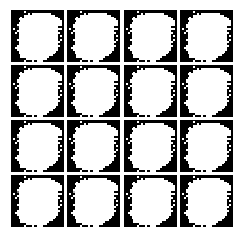

############################
Iter: 26000
D loss: 1.354e+03
G_loss: 1.538e+03


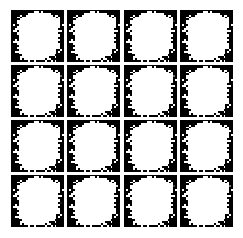

############################
Iter: 27000
D loss: 1.384e+03
G_loss: 1.393e+03


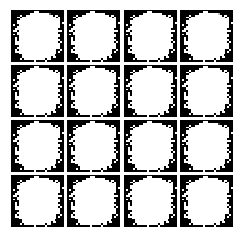

############################
Iter: 28000
D loss: 1.408e+03
G_loss: 1.39e+03


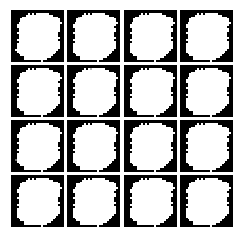

############################
Iter: 29000
D loss: 1.441e+03
G_loss: 1.39e+03


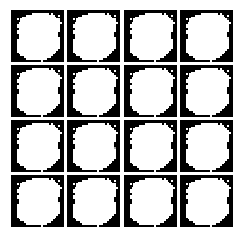

############################
Iter: 30000
D loss: 1.453e+03
G_loss: 1.674e+03


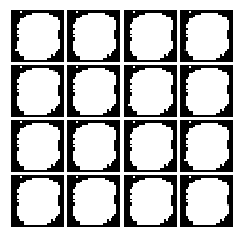

############################
Iter: 31000
D loss: 1.496e+03
G_loss: 1.505e+03


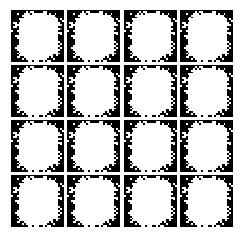

############################
Iter: 32000
D loss: 1.508e+03
G_loss: 1.502e+03


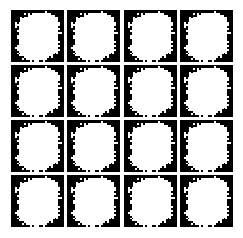

############################
Iter: 33000
D loss: 1.548e+03
G_loss: 1.502e+03


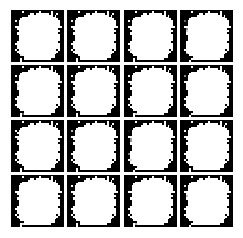

############################
Iter: 34000
D loss: 1.564e+03
G_loss: 1.728e+03


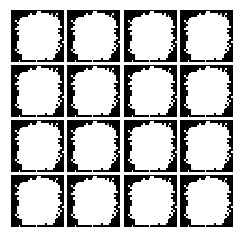

############################
Iter: 35000
D loss: 1.607e+03
G_loss: 1.614e+03


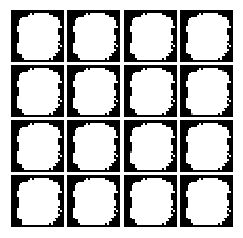

############################
Iter: 36000
D loss: 1.612e+03
G_loss: 1.614e+03


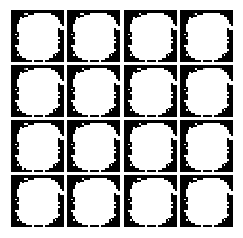

############################
Iter: 37000
D loss: 1.656e+03
G_loss: 1.614e+03


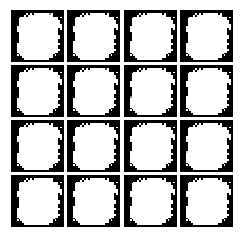

############################
Iter: 38000
D loss: 1.672e+03
G_loss: 1.614e+03


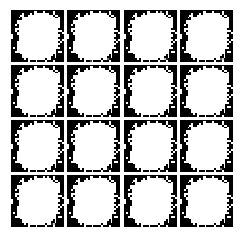

############################
Iter: 39000
D loss: 1.723e+03
G_loss: 1.614e+03


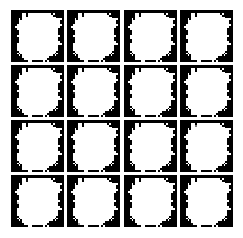

############################
Iter: 40000
D loss: 1.705e+03
G_loss: 2.174e+03


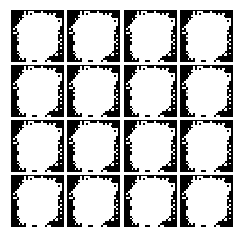

############################
Iter: 41000
D loss: 1.778e+03
G_loss: 1.726e+03


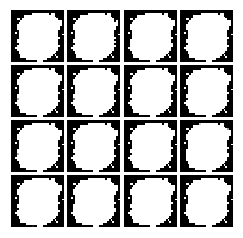

############################
Iter: 42000
D loss: 1.769e+03
G_loss: 1.838e+03


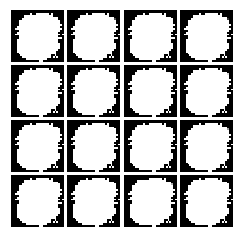

############################
Iter: 43000
D loss: 1.834e+03
G_loss: 1.838e+03


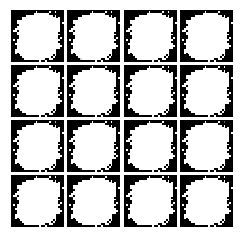

############################
Iter: 44000
D loss: 1.814e+03
G_loss: 1.838e+03


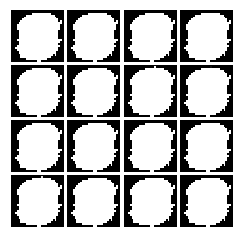

############################
Iter: 45000
D loss: 1.869e+03
G_loss: 1.838e+03


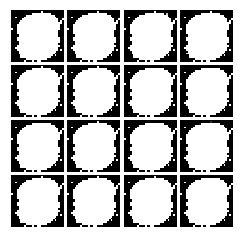

############################
Iter: 46000
D loss: 1.917e+03
G_loss: 1.838e+03


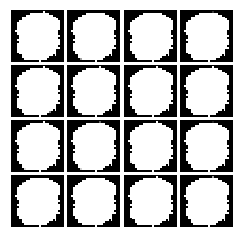

############################
Iter: 47000
D loss: 1.925e+03
G_loss: 1.838e+03


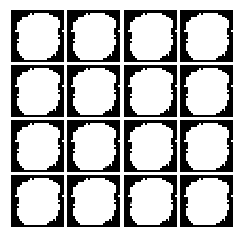

############################
Iter: 48000
D loss: 1.912e+03
G_loss: 2.357e+03


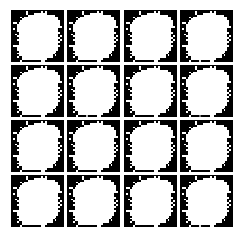

############################
Iter: 49000
D loss: 1.971e+03
G_loss: 1.95e+03


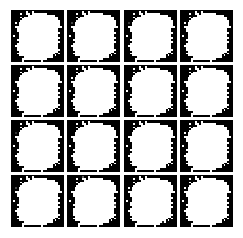

############################
Iter: 50000
D loss: 2.058e+03
G_loss: 1.95e+03


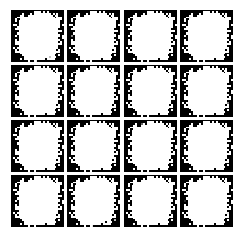

############################
Iter: 51000
D loss: 2.022e+03
G_loss: 1.95e+03


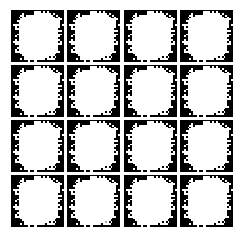

############################
Iter: 52000
D loss: 2.008e+03
G_loss: 3.079e+03


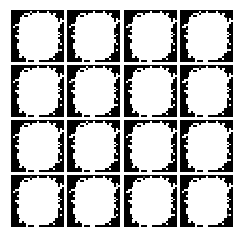

############################
Iter: 53000
D loss: 2.05e+03
G_loss: 2.174e+03


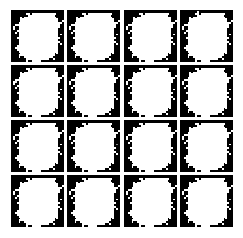

############################
Iter: 54000
D loss: 2.19e+03
G_loss: 2.174e+03


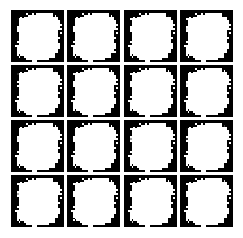

############################
Iter: 55000
D loss: 2.129e+03
G_loss: 2.174e+03


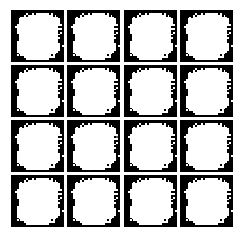

############################
Iter: 56000
D loss: 2.13e+03
G_loss: 2.174e+03


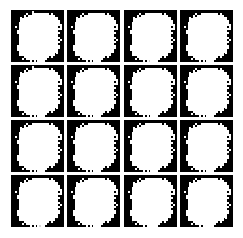

############################
Iter: 57000
D loss: 2.141e+03
G_loss: 2.174e+03


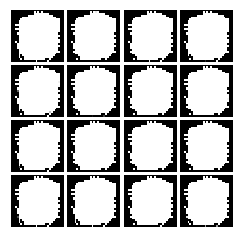

############################
Iter: 58000
D loss: 2.257e+03
G_loss: 2.174e+03


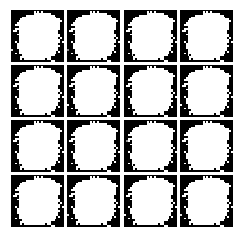

############################
Iter: 59000
D loss: 2.225e+03
G_loss: 2.174e+03


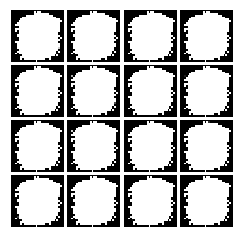

############################
Iter: 60000
D loss: 2.225e+03
G_loss: 2.174e+03


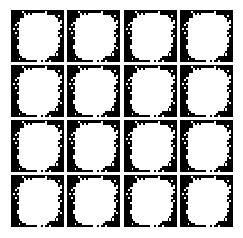

############################
Iter: 61000
D loss: 2.247e+03
G_loss: 2.174e+03


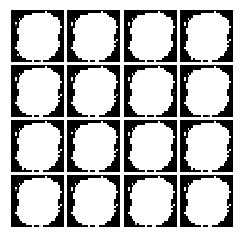

############################
Iter: 62000
D loss: 2.346e+03
G_loss: 2.174e+03


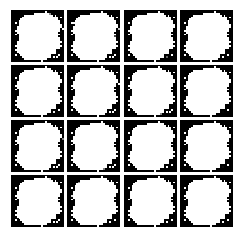

############################
Iter: 63000
D loss: 2.296e+03
G_loss: 2.174e+03


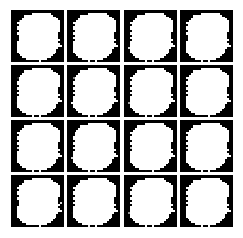

############################
Iter: 64000
D loss: 2.381e+03
G_loss: 2.174e+03


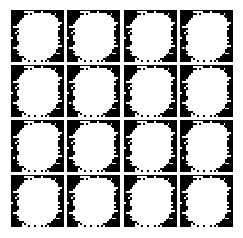

############################
Iter: 65000
D loss: 2.36e+03
G_loss: 2.174e+03


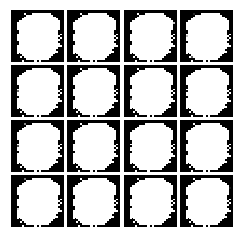

############################
Iter: 66000
D loss: 2.424e+03
G_loss: 2.398e+03


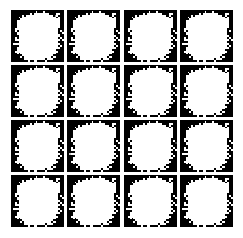

############################
Iter: 67000
D loss: 2.404e+03
G_loss: 2.398e+03


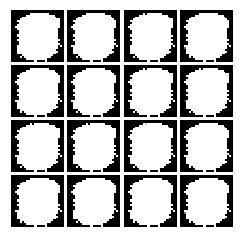

############################
Iter: 68000
D loss: 2.403e+03
G_loss: 2.785e+03


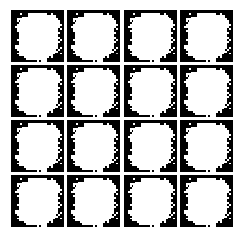

############################
Iter: 69000
D loss: 2.502e+03
G_loss: 2.622e+03


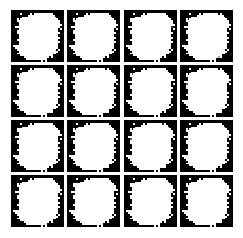

############################
Iter: 70000
D loss: 2.475e+03
G_loss: 2.622e+03


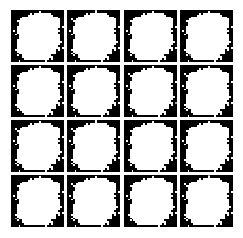

############################
Iter: 71000
D loss: 2.731e+03
G_loss: 2.622e+03


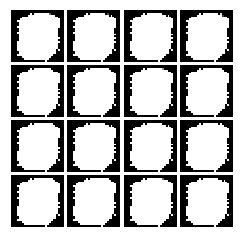

############################
Iter: 72000
D loss: 2.574e+03
G_loss: 2.398e+03


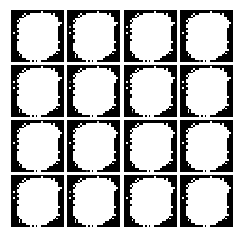

############################
Iter: 73000
D loss: 2.673e+03
G_loss: 2.398e+03


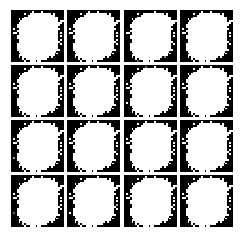

############################
Iter: 74000
D loss: 2.628e+03
G_loss: 2.398e+03


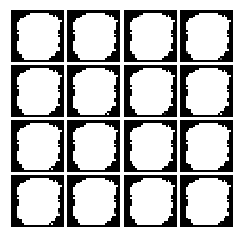

############################
Iter: 75000
D loss: 2.622e+03
G_loss: 5.682e+03


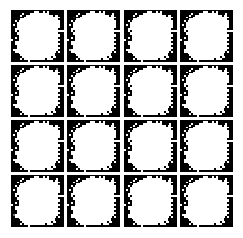

############################
Iter: 76000
D loss: 2.624e+03
G_loss: 2.908e+03


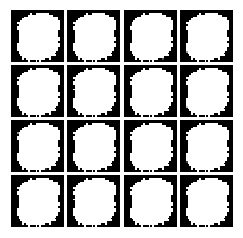

############################
Iter: 77000
D loss: 2.714e+03
G_loss: 2.846e+03


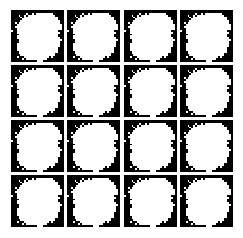

############################
Iter: 78000
D loss: 2.671e+03
G_loss: 2.846e+03


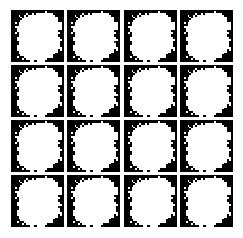

############################
Iter: 79000
D loss: 3.101e+03
G_loss: 2.846e+03


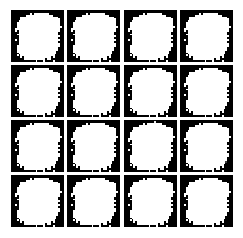

############################
Iter: 80000
D loss: 2.733e+03
G_loss: 2.846e+03


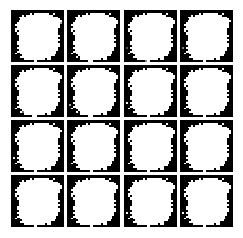

############################
Iter: 81000
D loss: 2.87e+03
G_loss: 2.846e+03


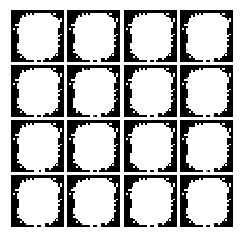

############################
Iter: 82000
D loss: 2.829e+03
G_loss: 2.846e+03


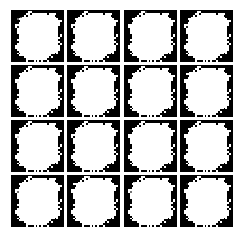

############################
Iter: 83000
D loss: 2.909e+03
G_loss: 2.846e+03


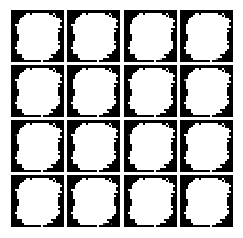

############################
Iter: 84000
D loss: 2.848e+03
G_loss: 2.846e+03


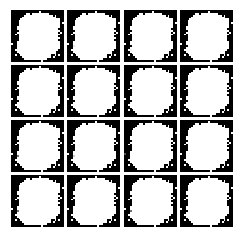

############################
Iter: 85000
D loss: 2.888e+03
G_loss: 2.846e+03


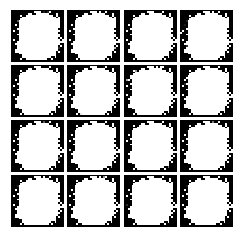

############################
Iter: 86000
D loss: 2.886e+03
G_loss: 2.846e+03


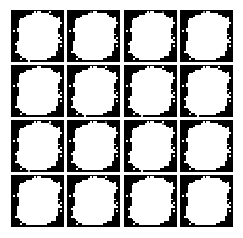

############################
Iter: 87000
D loss: 3.326e+03
G_loss: 2.846e+03


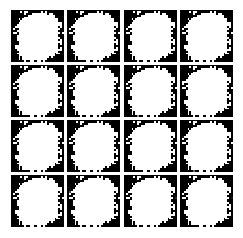

############################
Iter: 88000
D loss: 2.976e+03
G_loss: 2.846e+03


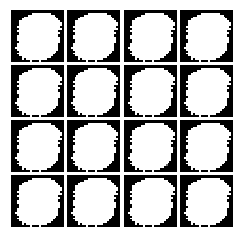

############################
Iter: 89000
D loss: 3.016e+03
G_loss: 2.846e+03


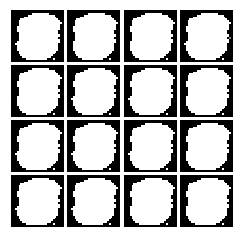

############################
Iter: 90000
D loss: 2.992e+03
G_loss: 2.846e+03


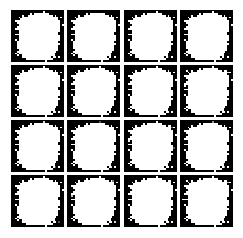

############################
Iter: 91000
D loss: 3.062e+03
G_loss: 2.846e+03


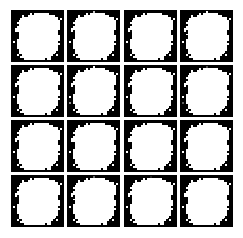

############################
Iter: 92000
D loss: 3.066e+03
G_loss: 2.846e+03


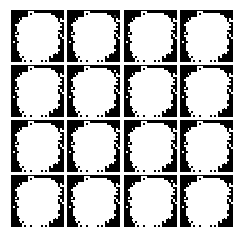

############################
Iter: 93000
D loss: 3.098e+03
G_loss: 2.846e+03


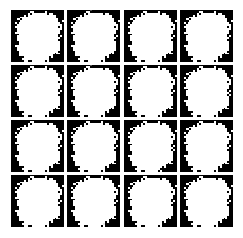

############################


In [ ]:
from tqdm import tqdm_notebook
bar = tqdm_notebook(range(max_iter), leave=False)
for it in bar:
    X, _ = mnist.train.next_batch(batch_size)
    
    _, d_loss_curr = sess.run([d_optimizer, d_loss], feed_dict={input_img: X, Z: sample_Z(batch_size, Z_dim)})
    _, g_loss_curr = sess.run([g_optimizer, g_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(d_loss_curr))
        print('G_loss: {:.4}'.format(g_loss_curr))
                                     
        samples = sess.run(g_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()
        plt.close(fig)
        print('############################')        